# LLM in-context learning experiment
In-context learning is an interesting emergent property of LLMs where an LLM can perform a task simply by being prompted input-output values, without optimizing any parameters (like one might do with fine-tuning). For more information, see this [blog post](https://ai.stanford.edu/blog/understanding-incontext/) from Stanford AI:

> During in-context learning, we give the LM a prompt that consists of a list of input-output pairs that demonstrate a task. At the end of the prompt, we append a test input and allow the LM to make a prediction just by conditioning on the prompt and predicting the next tokens. To correctly answer the two prompts below, the model needs to read the training examples to figure out the input distribution (financial or general news), output distribution (Positive/Negative or topic), input-output mapping (sentiment or topic classification), and the formatting.

In-context learning is competitive with models trained on labeled data. It typically requires very few labeled data examples. We know that few-shot learning is also probably effective for classification; see this [experiment](https://snorkel.ai/few-shot-learning-large-language-models/) conducted by Snorkel AI, where even 3 shots (examples) performed at a higher level than an LLM trained on none.

Our previous experiment with a "vanilla" Llama 3 (no fine-tuning or in-context learning) still performed somewhat well, with an accuracy of 68% and a recall of 96%. We notice, however, that its precision (55%) is quite low, which suggests that we need to help it get better at identifying non-CS articles articles correctly. In-context learning can help us do that, allowing us to increase the precision and accuracy.

### Creating the prompt

We use ChatGPT to help construct the prompt, after telling it the kind of task we are attempting to accomplish. From this, we get the following template:

```
Task: Classify each abstract as Computer Science (0) or non-Computer Science (1). Use the given examples as a guide.

Context: Computer Science abstracts often discuss subjects such as algorithms, machine learning, software development, computer systems, and data science. In contrast, non-CS abstracts address topics outside of these areas, like biology, statistics, physics, and finance.

Example 1:
Abstract: {abstract_1}
Classification: 1

Example 2:
Abstract: {abstract_2}
Classification: 0

Example 3:
Abstract: {abstract_3}
Classification: 1

Example 4:
Abstract: {abstract_4}
Classification: 0

Example 5:
Abstract: {abstract_5}
Classification: 0

Now, classify the following abstract:

Abstract: {abstract_6}
Classification:
```

We choose the last four items in the dataset, which are composed of three non-CS articles and one CS article. This is good, because our model was previously bad at classifying non-CS articles. More labeled examples of non-CS articles might make it better at identifying non-CS articles. We use only four items because the model tends to run for a long time if given an excessively long prompt.

This prompt is modified slightly from what ChatGPT produced, based on some initial tests.

In [22]:
def create_prompt(abstract):
    prompt = f'''Task: Classify each abstract as Computer Science (1) or non-Computer Science (0). Please only respond "1" or "0". Use the given examples as a guide.

Context: Computer Science abstracts often discuss subjects such as algorithms, machine learning, software development, computer systems, and data science. In contrast, non-CS abstracts address topics outside of these areas, like biology, statistics, physics, and finance.

Example 1:
Abstract: "We present numerical evidence that most two-dimensional surface states of a bulk topological superconductor (TSC) sit at an integer quantum Hall plateau transition. We study TSC surface states in class CI with quenched disorder. Low-energy (finite-energy) surface states were expected to be critically delocalized (Anderson localized). We confirm the low-energy picture, but find instead that finite-energy states are also delocalized, with universal statistics that are independent of the TSC winding number, and consistent with the spin quantum Hall plateau transition (percolation)."
Classification: 0

Example 2:
Abstract: "In this paper, we propose a new algorithm based on radial symmetry center method to track colloidal particles close to contact, where the optical images of the particles start to overlap in digital video microscopy. This overlapping effect is important to observe the pair interaction potential in colloidal studies and it appears as additional interaction in the measurement of the interaction with conventional tracking analysis. The proposed algorithm in this work is simple, fast and applicable for not only two particles but also three and more particles without any modification. The algorithm uses gradient vectors of the particle intensity distribution, which allows us to use a part of the symmetric intensity distribution in the calculation of the actual particle position. In this study, simulations are performed to see the performance of the proposed algorithm for two and three particles, where the simulation images are generated by using fitted curve to experimental particle image for different sized particles. As a result, the algorithm yields the maximum error smaller than 2 nm for 5.53 mu silica particles in contact condition."
Classification: 0

Example 3:
Abstract: "Queueing networks are systems of theoretical interest that give rise to complex families of stochastic processes, and find widespread use in the performance evaluation of interconnected resources. Yet, despite their importance within applications, and in comparison to their counterpart stochastic models in genetics or mathematical biology, there exist few relevant approaches for transient inference and uncertainty quantification tasks in these systems. This is a consequence of strong computational impediments and distinctive properties of the Markov jump processes induced by queueing networks. In this paper, we offer a comprehensive overview of the inferential challenge and its comparison to analogue tasks within related mathematical domains. We then discuss a model augmentation over an approximating network system, and present a flexible and scalable variational Bayesian framework, which is targeted at general-form open and closed queueing systems, with varied service disciplines and priorities. The inferential procedure is finally validated in a couple of uncertainty quantification tasks for network service rates."
Classification: 1

Example 4:
Abstract: "We construct Hall algebra of elliptic curve over $\\mathbb F_1$ using the theory of monoidal scheme due to Deitmar and the theory of Hall algebra for monoidal representations due to Szczesny. The resulting algebra is shown to be a specialization of elliptic Hall algebra studied by Burban and Schiffmann. Thus our algebra is isomorphic to the skein algebra for torus by the recent work of Morton and Samuelson."
Classification: 0

Now, classify the following abstract:

Abstract: {abstract}
Classification: '''
    return prompt

Next, we define a labeling function that uses Llama 3:

In [8]:
import ollama
import pandas as pd

In [12]:
def label_abstract(x):
    prompt = create_prompt(x)
    response = ollama.chat(model='llama3', messages=[
      {
        'role': 'user',
        'content': prompt,
      },
    ])
    return response['message']['content']

### Labeling the data

In [10]:
df = pd.read_csv("data/text-classification-train.csv")
df.head()

ID                                              TITLE  \
0   1        Reconstructing Subject-Specific Effect Maps   
1   2                 Rotation Invariance Neural Network   
2   3  Spherical polyharmonics and Poisson kernels fo...   
3   4  A finite element approximation for the stochas...   
4   5  Comparative study of Discrete Wavelet Transfor...   

                                            ABSTRACT  Computer Science  \
0    Predictive models allow subject-specific inf...                 1   
1    Rotation invariance and translation invarian...                 1   
2    We introduce and develop the notion of spher...                 0   
3    The stochastic Landau--Lifshitz--Gilbert (LL...                 0   
4    Fourier-transform infra-red (FTIR) spectra o...                 1   

   Physics  Mathematics  Statistics  Quantitative Biology  \
0        0            0           0                     0   
1        0            0           0                     0   
2        0            1           0                     0   
3        0            1           0                     0   
4        0            0           1                     0   

   Quantitative Finance  
0                     0  
1                     0  
2                     0  
3                     0  
4                     0

In [11]:
df_labeled = pd.DataFrame()
df_labeled["abstract"] = df["ABSTRACT"][:200]
df_labeled["CS_actual"] = df["Computer Science"][:200]
df_labeled

abstract  CS_actual
0      Predictive models allow subject-specific inf...          1
1      Rotation invariance and translation invarian...          1
2      We introduce and develop the notion of spher...          0
3      The stochastic Landau--Lifshitz--Gilbert (LL...          0
4      Fourier-transform infra-red (FTIR) spectra o...          1
..                                                 ...        ...
195    We relate the concepts used in decentralized...          0
196    Time-varying network topologies can deeply i...          1
197    A long-standing obstacle to progress in deep...          1
198    We study the band structure topology and eng...          0
199    Boundary value problems for Sturm-Liouville ...          0

[200 rows x 2 columns]

In [23]:
df_labeled["Llama3_ic_CS"] = 0

In [24]:
# Chunk 1
df_labeled['Llama3_ic_CS'][:50] = df_labeled['abstract'][:50].apply(label_abstract)

C:\Users\aharve\AppData\Local\Temp\ipykernel_10048\395338111.py:2: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df_labeled['Llama3_ic_CS'][:50] = df_labeled['abstract'][:50].apply(label_abstract)
C:\Users\aharve\AppData\Local\Temp\ipykernel

### Refining the prompt
The model still produces consistently wrong answers. On a sample of 50 articles, it scored a dismal ~50% in accuracy. It tends to label non-CS articles as CS articles, even when given many examples of non-CS articles that should be classified as CS articles. I expect similar results for the other 150 articles, so rather than wasting time computing those, I will refine the prompt and run the code again:

```
Task: Classify each abstract as Computer Science (CS) or non-Computer Science (non-CS). Please only respond "CS" if you are *very* confident that it is a CS abstract; otherwise, respond "non-CS". Use the given examples as a guide.

Context: Computer Science abstracts often discuss subjects such as algorithms, machine learning, software development, computer systems, and data science. In contrast, non-CS abstracts address topics outside of these areas, like biology, statistics, physics, and finance.

Example 1:
Abstract: "We present numerical evidence that most two-dimensional surface states of a bulk topological superconductor (TSC) sit at an integer quantum Hall plateau transition. We study TSC surface states in class CI with quenched disorder. Low-energy (finite-energy) surface states were expected to be critically delocalized (Anderson localized). We confirm the low-energy picture, but find instead that finite-energy states are also delocalized, with universal statistics that are independent of the TSC winding number, and consistent with the spin quantum Hall plateau transition (percolation)."
Classification: non-CS
Reason: The subject is physics, not computer science.

Example 2:
Abstract: "Polycrystalline diamond coatings have been grown on cemented carbide substrates with different aspect ratios by a microwave plasma CVD in methane-hydrogen gas mixtures. To protect the edges of the substrates from non-uniform heating due to the plasma edge effect, a special plateholder with pockets for group growth has been used. The difference in heights of the substrates and plateholder, and its influence on the diamond film mean grain size, growth rate, phase composition and stress was investigated. The substrate temperature range, within which uniform diamond films are produced with good adhesion, is determined. The diamond-coated cutting inserts produced at optimized process exhibited a reduction of cutting force and wear resistance by a factor of two, and cutting efficiency increase by 4.3 times upon turning A390 Al-Si alloy as compared to performance of uncoated tools."
Classification: non-CS
Reason: The subject is physics, not computer science.

Example 3:
Abstract: "Machine learning is finding increasingly broad application in the physical sciences. This most often involves building a model relationship between a dependent, measurable output and an associated set of controllable, but complicated, independent inputs. We present a tutorial on current techniques in machine learning -- a jumping-off point for interested researchers to advance their work. We focus on deep neural networks with an emphasis on demystifying deep learning. We begin with background ideas in machine learning and some example applications from current research in plasma physics. We discuss supervised learning techniques for modeling complicated functions, beginning with familiar regression schemes, then advancing to more sophisticated deep learning methods. We also address unsupervised learning and techniques for reducing the dimensionality of input spaces. Along the way, we describe methods for practitioners to help ensure that their models generalize from their training data to as-yet-unseen test data.",
Classification: CS
Reason: The abstract discusses machine learning, which is a computer science concept.  

Example 4:
Abstract: "We construct Hall algebra of elliptic curve over $\\mathbb F_1$ using the theory of monoidal scheme due to Deitmar and the theory of Hall algebra for monoidal representations due to Szczesny. The resulting algebra is shown to be a specialization of elliptic Hall algebra studied by Burban and Schiffmann. Thus our algebra is isomorphic to the skein algebra for torus by the recent work of Morton and Samuelson."
Classification: non-CS
Reason: The subject is mathematics, not computer science. 

Now, classify the following abstract:

Abstract: {abstract}
Classification:
```

Based on suggestions from ChatGPT, I add a "reason" to each example. I also change the classification from numerical to text-based, and make it clear to the model to only answer "CS" if it is *very* confident that the article is a CS article. Finally, I replace the less obviously CS article with a more explict CS article. This is in case the model uses that more ambiguous example to justify calling other articles CS. THe article I replace fits into example 3, where I also shorten the example so that the runtime for each labeling process is shorter.

In [40]:
def create_prompt(abstract):
    prompt = f'''Task: Classify each abstract as Computer Science (CS) or non-Computer Science (non-CS). Please only respond "CS" if you are *very* confident that it is a CS abstract; otherwise, respond "non-CS". Use the given examples as a guide.

Context: Computer Science abstracts often discuss subjects such as algorithms, machine learning, software development, computer systems, and data science. In contrast, non-CS abstracts address topics outside of these areas, like biology, statistics, physics, and finance.

Example 1:
Abstract: "We present numerical evidence that most two-dimensional surface states of a bulk topological superconductor (TSC) sit at an integer quantum Hall plateau transition. We study TSC surface states in class CI with quenched disorder. Low-energy (finite-energy) surface states were expected to be critically delocalized (Anderson localized). We confirm the low-energy picture, but find instead that finite-energy states are also delocalized, with universal statistics that are independent of the TSC winding number, and consistent with the spin quantum Hall plateau transition (percolation)."
Classification: non-CS
Reason: The subject is physics, not computer science.

Example 2:
Abstract: "Polycrystalline diamond coatings have been grown on cemented carbide substrates with different aspect ratios by a microwave plasma CVD in methane-hydrogen gas mixtures. To protect the edges of the substrates from non-uniform heating due to the plasma edge effect, a special plateholder with pockets for group growth has been used. The difference in heights of the substrates and plateholder, and its influence on the diamond film mean grain size, growth rate, phase composition and stress was investigated. The substrate temperature range, within which uniform diamond films are produced with good adhesion, is determined. The diamond-coated cutting inserts produced at optimized process exhibited a reduction of cutting force and wear resistance by a factor of two, and cutting efficiency increase by 4.3 times upon turning A390 Al-Si alloy as compared to performance of uncoated tools."
Classification: non-CS
Reason: The subject is physics, not computer science.

Example 3:
Abstract: "Machine learning is finding increasingly broad application in the physical sciences. This most often involves building a model relationship between a dependent, measurable output and an associated set of controllable, but complicated, independent inputs. We present a tutorial on current techniques in machine learning -- a jumping-off point for interested researchers to advance their work. We focus on deep neural networks with an emphasis on demystifying deep learning. We begin with background ideas in machine learning and some example applications from current research in plasma physics. We discuss supervised learning techniques for modeling complicated functions, beginning with familiar regression schemes, then advancing to more sophisticated deep learning methods. We also address unsupervised learning and techniques for reducing the dimensionality of input spaces. Along the way, we describe methods for practitioners to help ensure that their models generalize from their training data to as-yet-unseen test data.",
Classification: CS
Reason: The abstract discusses machine learning, which is a computer science concept.  

Example 4:
Abstract: "We construct Hall algebra of elliptic curve over $\\mathbb F_1$ using the theory of monoidal scheme due to Deitmar and the theory of Hall algebra for monoidal representations due to Szczesny. The resulting algebra is shown to be a specialization of elliptic Hall algebra studied by Burban and Schiffmann. Thus our algebra is isomorphic to the skein algebra for torus by the recent work of Morton and Samuelson."
Classification: non-CS
Reason: The subject is mathematics, not computer science; abstracts must explicitly discuss computer science topics, even if the math discussed could be applicable to computer science.

Now, classify the following abstract:

Abstract: {abstract}
Classification: '''
    return prompt

In [65]:
def label_abstract(x):
    prompt = create_prompt(x)
    response = ollama.chat(model='llama3', messages=[
      {
        'role': 'user',
        'content': prompt,
      },
    ])
    print(response['message']['content'])
    if 'non-CS' in response['message']['content'][:10]: # Restrict to only beginning
        return 0
    return 1

In [44]:
df_labeled['Llama3_ic2_CS'] = 0

**Chunk 1 (first 25)**

In [45]:
# Chunk 1
df_labeled['Llama3_ic2_CS'][:25] = df_labeled['abstract'][:25].apply(label_abstract)

CS

Reason: The abstract discusses predictive models, binary classifiers, and machine learning concepts, which are all computer science topics. Additionally, the abstract mentions neuroimaging data analysis and Alzheimer's disease, but these subjects are not the primary focus of the abstract; rather, they serve as a context for applying computer science techniques to improve subject-specific inference and detection accuracy.
CS
non-CS

Reason: The subject is mathematics, specifically spherical harmonics and polyharmonics, which are not directly related to computer science. While mathematical concepts can be used in computer science, this abstract does not explicitly discuss computer science topics.
non-CS

Reason: The abstract discusses physics and mathematics topics (Landau-Lifshitz-Gilbert equation, Maxwell equations) without explicitly discussing computer science concepts. Although the abstract mentions numerical methods and approximation schemes, these do not constitute a sufficien

C:\Users\aharve\AppData\Local\Temp\ipykernel_10048\2810415714.py:2: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df_labeled['Llama3_ic2_CS'][:25] = df_labeled['abstract'][:25].apply(label_abstract)
C:\Users\aharve\AppData\Local\Temp\ipykern

In [48]:
df_labeled[:25]

abstract  CS_actual Llama3_ic_CS  \
0     Predictive models allow subject-specific inf...          1            1   
1     Rotation invariance and translation invarian...          1            1   
2     We introduce and develop the notion of spher...          0            1   
3     The stochastic Landau--Lifshitz--Gilbert (LL...          0            1   
4     Fourier-transform infra-red (FTIR) spectra o...          1            1   
5     Let $\Omega \subset \mathbb{R}^n$ be a bound...          0            1   
6     We observed the newly discovered hyperbolic ...          0            0   
7     The ability of metallic nanoparticles to sup...          0            1   
8     We model large-scale ($\approx$2000km) impac...          0            1   
9     Time varying susceptibility of host at indiv...          0            1   
10    We present a systematic global sensitivity a...          1            1   
11    "Three is a crowd" is an old proverb that ap...          0            1   
12    We study the exciton magnetic polaron (EMP) ...          0            0   
13    The classical Eilenberg correspondence, base...          1            1   
14    Using low-temperature Magnetic Force Microsc...          0            1   
15    The recent discovery that the exponent of ma...          0            1   
16    The process that leads to the formation of t...          0            0   
17    We describe a variant construction of the un...          0            1   
18    When investigators seek to estimate causal e...          0            1   
19    Assigning homogeneous boundary conditions, s...          0            1   
20    The impact of random fluctuations on the dyn...          0            1   
21    Rare regions with weak disorder (Griffiths r...          0            1   
22    The Fault Detection and Isolation Tools (FDI...          1            1   
23    Detectability of discrete event systems (DES...          1            1   
24    Let $X$ be a partially ordered set with the ...          0            1   

    Llama3_ic2_CS  
0               1  
1               1  
2               0  
3               0  
4               0  
5               0  
6               0  
7               0  
8               0  
9               0  
10              0  
11              0  
12              0  
13              0  
14              0  
15              0  
16              0  
17              0  
18              1  
19              0  
20              0  
21              0  
22              1  
23              1  
24              0

This classification model does a *much* better job. It notably defaults to being more cautious about labeling articles as CS, defaulting to 0 instead. Let's see what it didn't classify correctly:

In [50]:
df_labeled.loc[18]["abstract"]

'  When investigators seek to estimate causal effects, they often assume that\nselection into treatment is based only on observed covariates. Under this\nidentification strategy, analysts must adjust for observed confounders. While\nbasic regression models have long been the dominant method of statistical\nadjustment, more robust methods based on matching or weighting have become more\ncommon. Of late, even more flexible methods based on machine learning methods\nhave been developed for statistical adjustment. These machine learning methods\nare designed to be black box methods with little input from the researcher.\nRecent research used a data competition to evaluate various methods of\nstatistical adjustment and found that black box methods out performed all other\nmethods of statistical adjustment. Matching methods with covariate\nprioritization are designed for direct input from substantive investigators in\ndirect contrast to black methods. In this article, we use a different rese

Many machine learning techniques might be classified as statistics rather than computer science, so this error is understandable. Clearly, it fits more into statistics than computer science, but I'm not sure exactly how to code that difference into a prompt.
> Reason: The abstract discusses machine learning, which is a computer science concept, and specifically mentions methods for statistical adjustment in causal inference, which is a subfield of artificial intelligence (AI) and data science.


In [51]:
df_labeled.loc[13]["abstract"]

'  The classical Eilenberg correspondence, based on the concept of the syntactic\nmonoid, relates varieties of regular languages with pseudovarieties of finite\nmonoids. Various modifications of this correspondence appeared, with more\ngeneral classes of regular languages on one hand and classes of more complex\nalgebraic structures on the other hand. For example, classes of languages need\nnot be closed under complementation or all preimages under homomorphisms, while\nmonoids can be equipped with a compatible order or they can have a\ndistinguished set of generators. Such generalized varieties and pseudovarieties\nalso have natural counterparts formed by classes of finite (ordered) automata.\nIn this paper the previous approaches are combined. The notion of positive\n$\\mathcal C$-varieties of ordered semiautomata (i.e. no initial and final\nstates are specified) is introduced and their correspondence with positive\n$\\mathcal C$-varieties of languages is proved.\n'

The only CS-related prompt is heavily ML-related. Maybe because of this, it sees this highly theoretical CS research article as not CS when it is.
> Reason: The subject is mathematics, specifically the study of algebraic structures and regular languages, which is not a computer science topic. Although the abstract mentions finite automata, which could be relevant to computer science, it does not explicitly discuss computer science concepts or applications.


In [52]:
df_labeled.loc[10]["abstract"]

'  We present a systematic global sensitivity analysis using the Sobol method\nwhich can be utilized to rank the variables that affect two quantity of\ninterests -- pore pressure depletion and stress change -- around a\nhydraulically-fractured horizontal well based on their degree of importance.\nThese variables include rock properties and stimulation design variables. A\nfully-coupled poroelastic hydraulic fracture model is used to account for pore\npressure and stress changes due to production. To ease the computational cost\nof a simulator, we also provide reduced order models (ROMs), which can be used\nto replace the complex numerical model with a rather simple analytical model,\nfor calculating the pore pressure and stresses at different locations around\nhydraulic fractures. The main findings of this research are: (i) mobility,\nproduction pressure, and fracture half-length are the main contributors to the\nchanges in the quantities of interest. The percentage of the contribution

I would find it hard to classify this as a CS article. It looks like our model did too:
> Reason: The subject is physics/statistics, specifically related to hydraulic fracturing, poroelastic models, and sensitivity analysis. While these topics may involve computational simulations, they do not explicitly discuss computer science concepts like algorithms, machine learning, software development, or data science.

In [53]:
df_labeled.loc[4]["abstract"]

'  Fourier-transform infra-red (FTIR) spectra of samples from 7 plant species\nwere used to explore the influence of preprocessing and feature extraction on\nefficiency of machine learning algorithms. Wavelet Tensor Train (WTT) and\nDiscrete Wavelet Transforms (DWT) were compared as feature extraction\ntechniques for FTIR data of medicinal plants. Various combinations of signal\nprocessing steps showed different behavior when applied to classification and\nclustering tasks. Best results for WTT and DWT found through grid search were\nsimilar, significantly improving quality of clustering as well as\nclassification accuracy for tuned logistic regression in comparison to original\nspectra. Unlike DWT, WTT has only one parameter to be tuned (rank), making it a\nmore versatile and easier to use as a data processing tool in various signal\nprocessing applications.\n'

Interestingly, this is actually mis-classified. The model actually chose it to be a CS article, but because the reason contained the phrase "non-CS" in it, it was classified as non-CS. We therefore modify the model slightly to address this issue. See the reason below:
>  Reason: The abstract discusses machine learning, feature extraction, and signal processing techniques, which are all computer science topics. The fact that the spectra being analyzed come from plant samples does not make it non-CS; the methods used to analyze the data are the primary focus of the abstract.

**Chunk 2 (second 25)**

In [66]:
# Chunk 2
df_labeled['Llama3_ic2_CS'][25:50] = df_labeled['abstract'][25:50].apply(label_abstract)

CS

Reason: The abstract discusses algorithms for computing integrals, which is a computer science topic related to computational mathematics and scientific computing.
CS

Reason: The abstract discusses computer science topics such as algorithms (ray tracing based sound propagation algorithm, particle filter), machine learning (localization of 3D position of the sound source), and software development (simulation of diffraction acoustic rays).
non-CS

Reason: The subject appears to be biology (pea-crossbreeding) and mathematics/statistics (factorization formulas, kindred elements), but not computer science.
CS
non-CS

Reason: The subject is physics/statistics, not computer science. The abstract discusses conservation laws, probability concentration, and large deviation functions, which are topics in mathematics or statistics, but not explicitly related to computer science.
CS
non-CS

Reason: The subject appears to be mathematics and geometric measure theory, which are not explicitly re

C:\Users\aharve\AppData\Local\Temp\ipykernel_10048\2631434717.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_labeled['Llama3_ic2_CS'][25:50] = df_labeled['abstract'][25:50].apply(label_abstract)


**Chunk 3 (50-100)**

In [82]:
# Chunk 3
df_labeled['Llama3_ic2_CS'][50:100] = df_labeled['abstract'][50:100].apply(label_abstract)

CS

Reason: The abstract discusses machine learning algorithms, neural networks, and contextual regression, which are all computer science topics.
non-CS

Reason: Although the abstract mentions "multi-time correlators" and "quantum Bayesian formalism", it appears to be discussing physics and quantum mechanics rather than computer science. The concepts discussed are not explicitly related to computer science topics like algorithms, machine learning, software development, or computer systems.
CS
CS

Reason: The abstract discusses algorithms and machine learning concepts (bidirectional LSTM network, domain adversarial training) specifically designed for automatic assessment of voice disorders. The topic is computer science-related, as it involves the development of a detection system using neural networks and techniques to increase robustness against channel mismatch.
CS

Reason: The abstract discusses a computer science topic (computational number theory) and algorithms, which are a fund

C:\Users\aharve\AppData\Local\Temp\ipykernel_10048\908760735.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_labeled['Llama3_ic2_CS'][50:100] = df_labeled['abstract'][50:100].apply(label_abstract)


**Chunk 4 (100-150)**

In [86]:
# Chunk 4
df_labeled['Llama3_ic2_CS'][100:150] = df_labeled['abstract'][100:150].apply(label_abstract)

CS
CS

Reason: The abstract discusses computer science concepts such as polynomial chaos and stochastic Galerkin methods, which are used in numerical analysis and simulation. While the underlying physics and mathematics may be complex, the focus on computational methods makes this a Computer Science (CS) abstract.
CS
non-CS

Reason: The subject is physics, specifically the study of the de Haas-van Alphen effect and angle resolved photoemission spectroscopy on single crystals of the metallic delafossite PdRhO2. While this abstract does mention a "high sensitivity torque magnetometry setup" and "synchrotron-based photoemission", these are not computer science topics, but rather tools used in physics research.
non-CS

Reason: The subject is mathematics/statistics, not computer science. Although some mathematical concepts may be applicable to computer science, this abstract does not explicitly discuss computer science topics.
non-CS

Reason: The subject is physics, specifically the study o

C:\Users\aharve\AppData\Local\Temp\ipykernel_10048\734700279.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_labeled['Llama3_ic2_CS'][100:150] = df_labeled['abstract'][100:150].apply(label_abstract)


**Chunk 5 (150-200)**

In [89]:
# Chunk 5
df_labeled['Llama3_ic2_CS'][150:200] = df_labeled['abstract'][150:200].apply(label_abstract)

CS

Reason: The abstract discusses Artificial Intelligence (AI), machine learning, computer vision, speech recognition, and machine translation, which are all computer science topics. Additionally, the abstract mentions systems software, architectures, and security, which further supports a classification of CS.
non-CS

Reason: The abstract discusses mathematical concepts such as topological groups, G-spaces, and infinite loop space theory, which are not explicitly related to computer science. While mathematics can be applied to computer science, this abstract does not contain any direct references or discussions of computer science topics, so I classify it as non-CS.
non-CS

Reason: The subject appears to be algebraic geometry and number theory, which are areas outside of computer science. While the concepts discussed may have implications for computer science, such as computational complexity or cryptography, the abstract does not explicitly discuss computer science topics.
non-CS

R

C:\Users\aharve\AppData\Local\Temp\ipykernel_10048\3775959131.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_labeled['Llama3_ic2_CS'][150:200] = df_labeled['abstract'][150:200].apply(label_abstract)


### Evaluating Llama 3 with in-context learning

<Axes: >

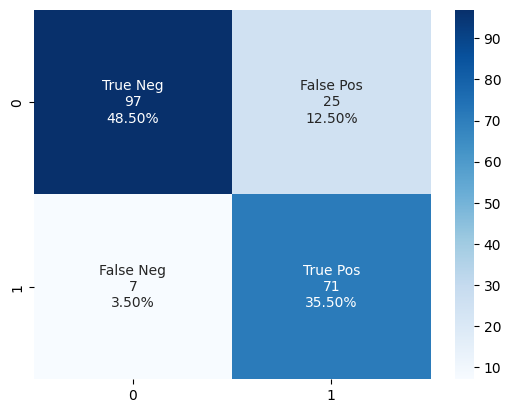

In [93]:
# Source: https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea

from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

cm = confusion_matrix(df_labeled['CS_actual'], df_labeled['Llama3_ic2_CS'])

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cm.flatten()/np.sum(cm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(cm, annot=labels, fmt="", cmap='Blues')

The biggest error commited by this model continues to be Type I errors, where it labels non-CS articles as CS articles. From the previous "vanilla" LLM experiment with Llama 3, we see a remarkable increase in true negatives and consequent decrease in false positives. The amount of false negatives increased slightly, while the true positives remained roughly the same.

Let's take a look at four key metrics for classification models: accuracy, precision, recall, and F1-score.

In [94]:
tn = cm[0][0]
fp = cm[0][1]
fn = cm[1][0]
tp = cm[1][1]

# Accuracy: the percent of correctly classified data
accuracy = (tn+tp)/(tn+fp+fn+tp)
accuracy

0.84

In [95]:
# Precision: positive predictive value; of those predicted as CS documents, how many were actually CS documents?
precision = (tp)/(tp+fp)
precision

0.7395833333333334

In [96]:
# Recall: of those that were actually CS documents, how many were predicted as CS documents?
recall = (tp)/(tp+fn)
recall

0.9102564102564102

In [97]:
# F1 score: tries to balance precision and recall, with uneven class distribution (large number of actual negs)
f1 = 2*((precision*recall)/(precision+recall))
f1

0.8160919540229885

Incredible! The model does as good or better on virtually every metric compared to the vanilla LLM model. We see a 14-point increase in accuracy, an almost 25-point increase in precision, a slight decrease in recall (96% to 91%), and an increase in F1-score to 0.81 (from 0.7).

Notably, this model also beats the previous Snorkel semantic similarity approach, with an increase in every metric. This is the best model by far. Some potential next steps:
1. In its output, the model also produced a "reason" for most of its labels. It would be interesting to look at its "reason" for articles it mis-classified and see if that might inform how we structure the prompt.
2. I didn't quite do this in the correct way. I used one prompt on the first 25 items, found that it performed badly, and modified the prompt based on those results. Obviously, the model performed well on the "unseen" data (25-200) but there is a small worry that it "overfitted" on the first 25.
3. Increasing the prompt length increases the runtime, but it might also make the model even more accurate. Nevertheless, my guess is that 50% of the misclassified entries are actually quite difficult to classify as CS, even for a human. In that way, maybe we should be happy with the 84% accuracy.